In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

train_x = np.linspace(1.0, 10.0, num=100)[:, np.newaxis]
train_y = np.sin(train_x) + 0.1 * np.power(train_x, 2) + 0.5 * np.random.randn(100, 1)

with np.load("TINY_MNIST.npz") as data:
    x, t = data["x"], data["t"]
    x_eval, t_eval = data["x_eval"], data["t_eval"]

In [34]:
def distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

def kNeighbors(trainSet, testCase, k):
    N, _ = trainSet.shape
    distances = [(distance(trainSet[idx], testCase), idx) for idx in range(N)]
    distances.sort(key=lambda t : t[0])
    neighbors = [idx for _, idx in distances[:k]]
    return neighbors

def getLabel(neighbors, labelSet):
    votes = {}
    for idx in neighbors:
        label = labelSet[idx][0]
        if label in votes:
            votes[label] += 1
        else:
            votes[label] = 1
    return max(votes, key=lambda i : votes[i])

# Task 1 : Training Size

N_set = [5, 50, 100, 200, 400, 800]
k0 = 1
print("%15s\t%15s" % ("Training Size", "Error Count"))
for N in N_set:
    t_prediction = [getLabel(kNeighbors(x[:N], testCase, k0), t[:N]) for testCase in x_eval]
    errorCount = 0
    for idx in range(len(t_prediction)):
        if t_prediction[idx] != t_eval[idx][0]:
            errorCount += 1
    print("%15d\t%15d" % (N, errorCount))


  Training Size	    Error Count
              5	            107
             50	             40
            100	             27
            200	             17
            400	              9
            800	             12


In [35]:
# Task 2 : Overfitting and Underfitting
k_set = [1, 3, 5, 7, 21, 101, 401]
print("%15s\t%15s" % ("k", "Error Count"))
for k in k_set:
    t_prediction = [getLabel(kNeighbors(x, testCase, k), t) for testCase in x_eval]
    errorCount = 0
    for idx in range(len(t_prediction)):
        if t_prediction[idx] != t_eval[idx][0]:
            errorCount += 1
    print("%15d\t%15d" % (k, errorCount))

              k	    Error Count
              1	             12
              3	              8
              5	             10
              7	              9
             21	             11
            101	             24
            401	             51


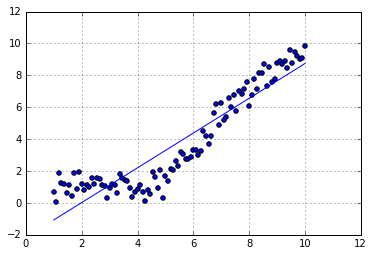

In [36]:
# Task 3 : Linear Fit

# our model is y_model = w' * train_x

def normalize(array):
    return array / array.std()

def genFeatureSet(m):
    n, _ = train_x.shape
    xnew = np.ones(n)[:, np.newaxis]
    for j in range(1, m):
        xnew = np.concatenate((xnew, normalize(train_x ** j)), axis=1)
    return xnew    

def gradientDescent(xData, theta, eta, numOfIterations):
    xTrans = xData.transpose()
    N, _ = xData.shape
    for _ in range(numOfIterations):
        model = np.dot(xData, theta)
        diff  = model - train_y
        cost  = np.sum(diff ** 2) / (2 * N)
        gradient = np.dot(xTrans, diff) / N
        theta = theta - eta * gradient
    return theta

learningRate = 0.01
iterationCount = 100000
J = 2
xData = genFeatureSet(J)
theta = np.ones(J)[:, np.newaxis]
theta = gradientDescent(xData, theta, learningRate, iterationCount)
plt.grid(True)
plt.scatter(train_x, train_y)
y_model = np.dot(xData, theta)
plt.plot(train_x, y_model)

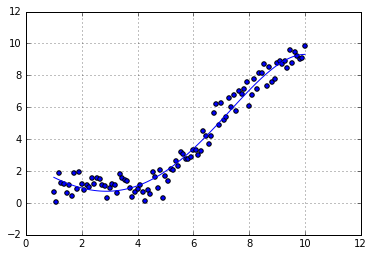

In [37]:
# Task 4 : Feature Space

learningRate = 0.01
iterationCount = 100000
J = 6 # goes to x^5
xData = genFeatureSet(J)
theta = np.ones(J)[:, np.newaxis]
theta = gradientDescent(xData, theta, learningRate, iterationCount)
plt.grid(True)
plt.scatter(train_x, train_y)
y_model = np.dot(xData, theta)
plt.plot(train_x, y_model)

In [61]:
# Task 5 : Training Size

def binaryDecision(array):
    N, _ = array.shape
    for idx in range(N):
        curr = 0
        if array[idx][0] >= 0.5:
            curr = 1.0
        array[idx][0] = curr
    return array

def predictWithRegressor(theta, x_validation, t_validation):
    N, _ = x_validation.shape
    t_prediction = binaryDecision(np.dot(x_validation, theta))
    return t_prediction, np.count_nonzero(np.subtract(t_validation, t_prediction))
    
def euclideanCost(diff, theta, lmbda):
    N, _ = diff.shape # N is the mini-batch size
    cost = (np.sum(diff ** 2) / N) + lmbda * np.sqrt(np.sum(theta ** 2))
    return cost / 2

def stochasticGradientDescent(N, theta, eta, lmbda, numOfIterations):
    rndIdx = np.random.choice(N, 1)
    yData = t[rndIdx]
    xData = x[rndIdx]
    xTrans = xData.transpose()
    for _ in range(numOfIterations):
        model = np.dot(xData, theta)
        diff = model - yData
        cost = euclideanCost(diff, theta, lmbda)
        gradient = np.dot(xTrans, diff) + (lmbda * theta)
        theta = theta - eta * gradient
    return theta
    
_, m = x.shape
theta = np.ones(m)[:, np.newaxis]
lmbda = 0
eta = 0.1

print("%15s\t%15s" % ("Training Size", "Error Count"))
for N in [100, 200, 400, 800]:
    theta = stochasticGradientDescent(N, theta, eta, lmbda, 10000)
    _, errorCount = predictWithRegressor(theta, x_eval, t_eval)
    print("%15d\t%15d" % (N, errorCount))
    

  Training Size	    Error Count
            100	            200
            200	            197
            400	            144
            800	            169


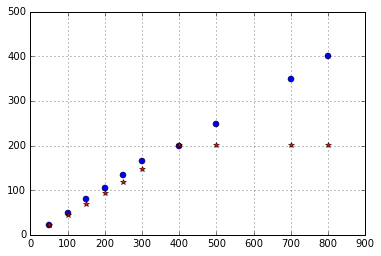

In [77]:
# Task 6 : Overfitting
theta = np.ones(m)[:, np.newaxis]
theta = stochasticGradientDescent(50, theta, eta, 0, 10000)

err_cnt_trn = []
err_cnt_vld = []
epoch_set = [50, 100, 150, 200, 250, 300, 400, 500, 700, 800]
for N in epoch_set:
    _, errorCount = predictWithRegressor(theta, x[:N], t[:N])
    err_cnt_trn.append( errorCount )
    _, errorCount = predictWithRegressor(theta, x_eval[:N], t_eval[:N])
    err_cnt_vld.append( errorCount )
plt.axis([0, 900, 0, 500])    
plt.plot(epoch_set, err_cnt_trn, 'bo', epoch_set, err_cnt_vld, 'r*')
plt.grid(True)

## What is the number of epochs?! What should I plot here?!

In [62]:
# Task 7 : Regularization
theta = np.ones(m)[:, np.newaxis]
print("%15s\t%15s\t%15s" % ("Training Size", "Lambda", "Error Count"))
for lmbda in [0, 0.0001, 0.001, 0.01, 0.1, 0.5]:
    theta = theta = stochasticGradientDescent(50, theta, eta, lmbda, 10000)
    _, errorCount = predictWithRegressor(theta, x_eval, t_eval)
    print("%15d\t%15f\t%15d" % (N, lmbda, errorCount))



  Training Size	         Lambda	    Error Count
            800	       0.000000	            200
            800	       0.000100	            190
            800	       0.001000	             90
            800	       0.010000	            214
            800	       0.100000	            200
            800	       0.500000	            200
